<a href="https://colab.research.google.com/github/alexeyphilippov/ChartWindow/blob/master/triplet_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import torch
if torch.cuda.is_available(): 
  print("Using GPU")
  torch.device('cuda')
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import cosine_similarity, relu, pairwise_distance
from torch.nn import BatchNorm1d
import torch.nn.functional as F

import matplotlib.pyplot as plt
import csv
from sklearn.metrics import roc_auc_score

PATH_FOR_DATA = "drive/My Drive/Python_for_colab/image-name/csvs/local_csvs/data.csv"
PATH_FOR_TEST = "drive/My Drive/Python_for_colab/image-name/csvs/local_csvs/data_test.csv"
PATH_FOR_TRAIN = "drive/My Drive/Python_for_colab/image-name/csvs/local_csvs/data_train.csv"
PATH_FOR_TRIPLET = "drive/My Drive/Python_for_colab/image-name/csvs/final_df_053000_triplet.csv"
PATH_TRIPLET_TRAIN = "drive/My Drive/Python_for_colab/image-name/csvs/local_csvs/triplet_train.csv"
PATH_TRIPLET_TEST = "drive/My Drive/Python_for_colab/image-name/csvs/local_csvs/triplet_test.csv"

Using GPU


In [0]:
class Batch_generator_triple():
    def __init__(self, path, batch_size:int=128): #, isTrain:bool=True

        self.path = path
        self.batch_size = batch_size
        
    def get_gen(self):
        with open(self.path, newline='') as csvfile:
          reader = csv.reader(csvfile, delimiter=',')
          k = 0
          A_batch_list = []
          P_batch_list = []
          N_batch_list = []

          for row in reader:
              try:
                  row = [float(s) for s in row]
                  A_batch_list.append(row[:1000])
                  P_batch_list.append(row[1000:1300])

                  N_batch_list.append(row[1300:])
                  k += 1
                  if k == self.batch_size:
                      k = 0 
                      yield torch.tensor(A_batch_list).cuda(), torch.tensor(P_batch_list).cuda(),torch.tensor(N_batch_list).cuda()
              except ValueError :
                  pass
              
    def get_test_gen(self):
      with open(self.path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        k = 0
        Image_batch_list = []
        Message_bach_list = []
        Label_batch_list = []
        for row in reader:
          try:
            row = [float(s) for s in row]
            Image_batch_list.append(row[:1000])
            Message_batch_list.append(row[1000:1300])
            Labbel_batch_list.append(row[-1])
            k += 1
            if k == self.batch_size:
              k = 0
              yield torch.tensor(Image_batch_list).cuda(), torch.tensor(Message_batch_list).cuda(), torch.tensor(Labels_batch_list).cuda()

          except ValueError:
            pass

In [0]:
"""
Triplet loss
Takes embeddings of an anchor sample, a positive sample and a negative sample
"""
"""     distance_positive = cosine_similarity(anchor, positive)
        distance_negative = cosine_similarity(anchor, negative)
"""
class TripletLoss(nn.Module):

  def __init__(self, margin=1):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
  def forward(self, distance_positive, distance_negative, size_average=True): # anchor, positive, negative,

        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [0]:
# from torch.nn.modules.loss import TripletMarginLoss
class TripletNet(nn.Module):
    def __init__(self):
      
        self.THRESHHOLD = 0
        super(TripletNet, self).__init__()

        self.A_layer = nn.Linear(1000, 100)

        self.PN_layer = nn.Linear(300, 100)
        
        self.loss = TripletLoss()
        

    def forward(self, a, p, n): # dim a = 1000, dim p = 300, dim n = 300
      
        result = dict()
        
        a = self.A_layer(a)

        p = self.PN_layer(p)

        n = self.PN_layer(n)
        
        distance_positive = cosine_similarity(a, p)
        distance_negative = cosine_similarity(a, n)
        
        triple_loss = self.loss(distance_positive=distance_positive,
                                distance_negative=distance_negative)
        
        
        result.update({
            "positive_dis":distance_positive,
            "negative_dis":distance_negative,
            "loss":triple_loss
        })

        return result
      
    def predict(self, word, image): #dim word = 1000, dim image = 300
      
      word = self.A_layer(word)
      image = self.PN_layer(image)
      
      distances = cosine_similarity(word, image)
        
      return distances
  
      
      
      

In [0]:
class Triplet_Net_coach():
    def __init__(self, net):
      self._is_trained = False
      self._net = net.cuda()
        
    def train(self, test_path, train_path, margin=1,):
        self.train_path = train_path
        self.test_path = test_path
      
      
      # TRAIN : Anchor(image), Positive(message), Negative(message)
      
      
        self._is_trained = True
        self._optimizer = torch.optim.Adam(self._net.parameters())

        self.epo = []
        self.los_train = []
        self.los_test = []

        N_EPOCHS = 10
        BATCH_SIZE = 128
        for epoch in range(N_EPOCHS):
            print("Epoch",epoch,"started")

            
            #TRAIN
            self._net.train()
            
            train_batch_gen = Batch_generator_triple(path=self.train_path)
            batch_loss = []
            for A, P, N in train_batch_gen.get_gen():

                output = self._net(A, P, N)
                loss_train = output["loss"]

                self._optimizer.zero_grad()
                loss_train.backward()
                self._optimizer.step()
                
                batch_loss.append(loss_train.item())

            self.los_train.append(np.mean(batch_loss))

      
            #TEST
            self._net.eval()
            
            test_batch_gen = Batch_generator_triple(path=self.test_path)
            batch_loss = []
            
            for A, P, N in test_batch_gen.get_gen():

                output = self._net(A, P, N)
                loss_test = output["loss"]
                
                batch_loss.append(loss_test.item())

            self.los_test.append(np.mean(batch_loss))
  
            print("Epoch", epoch)

        return [self.epo, self.los_train, self.los_test]
    
    def get_training_plot(self):
        if self._is_trained == False:
            raise Exception('Call .train() method first.')
        else:
            _, ax = plt.subplots()
            
            min_len = min(len(self.los_train), len(self.los_test))
            
            los_train, los_test = self.los_train[:min_len], self.los_test[:min_len]
            
            ax.plot(range(min_len), los_train, label='train')
            ax.plot(range(min_len), los_test, label='test')
            
            legend = ax.legend(loc='upper center', shadow=True,
                               fontsize='x-large')
    def get_net(self):
        return self._net

In [17]:
model = TripletNet()
coach = Triplet_Net_coach(net=model)
res = coach.train(test_path=PATH_TRIPLET_TEST, train_path=PATH_TRIPLET_TRAIN)

Epoch 0 started
Epoch 0
Epoch 1 started
Epoch 1
Epoch 2 started
Epoch 2
Epoch 3 started
Epoch 3
Epoch 4 started
Epoch 4
Epoch 5 started
Epoch 5
Epoch 6 started
Epoch 6
Epoch 7 started
Epoch 7
Epoch 8 started
Epoch 8
Epoch 9 started
Epoch 9


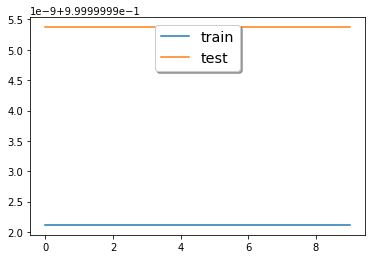

In [18]:
coach.get_training_plot()